# Import

In [1]:
import torch
from torch import nn as nn
from torch.nn import functional as F
import tqdm
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from replay.replay import ReplayBuffer, BufferFields, set_buffer_dim

# Load Data

In [2]:
device_id = 2
#with open('pkl/walker_replay_2state.pkl', 'rb') as fp:
#    replay_buffer = pickle.load(fp)
with open('pkl/walker_replay_noterm.pkl', 'rb') as fp:
    replay_buffer = pickle.load(fp)

print(replay_buffer._buffer.keys())
print(replay_buffer._buffer['state'].size(), replay_buffer._buffer['state'].device)
print(replay_buffer._buffer['action'].size(), replay_buffer._buffer['action'].device)
print(replay_buffer._buffer['reward'].size(), replay_buffer._buffer['reward'].device)
print(replay_buffer._buffer['prev_state'].size(), replay_buffer._buffer['prev_state'].device)
print(replay_buffer._buffer['prev_action'].size(), replay_buffer._buffer['prev_action'].device)
set_buffer_dim(17, 6) # walker
#set_buffer_dim(11, 3) # hopper

dict_keys(['state', 'action', 'reward', 'done', 'next_state', 'end', 'prev_state', 'prev_action'])
torch.Size([1000000, 17]) cuda:2
torch.Size([1000000, 6]) cuda:2
torch.Size([1000000, 1]) cuda:2


# Build Model

torch.Size([3, 5, 7])
torch.Size([3, 1, 7])


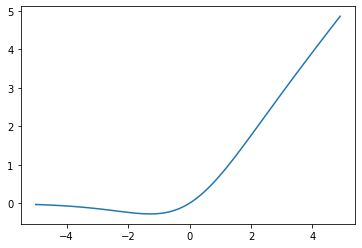

In [3]:
def swish(x):
    return x * torch.sigmoid(x)

def get_affine_params(ensemble_size, in_features, out_features):

    #w = truncated_normal(size=(ensemble_size, in_features, out_features),
    #                     std=1.0 / (2.0 * np.sqrt(in_features)))
    w = torch.torch.randn((ensemble_size, in_features, out_features)) * (1.0 / (2.0 * np.sqrt(in_features)))

    w = nn.Parameter(w)

    b = nn.Parameter(torch.zeros(ensemble_size, 1, out_features, dtype=torch.float32))

    return w, b

x = torch.arange(-5, 5, 0.1)
y = swish(x)
plt.plot(x, y)

w, b = get_affine_params(3, 5, 7)
print(w.shape)
print(b.shape)

In [4]:
TORCH_DEVICE = device_id
class PtModel(nn.Module):

    def __init__(self, ensemble_size, in_features, out_features):
        super().__init__()

        self.num_nets = ensemble_size

        self.in_features = in_features
        self.out_features = out_features

        self.lin0_w, self.lin0_b = get_affine_params(ensemble_size, in_features, 500)

        self.lin1_w, self.lin1_b = get_affine_params(ensemble_size, 500, 500)

        self.lin2_w, self.lin2_b = get_affine_params(ensemble_size, 500, 500)

        self.lin3_w, self.lin3_b = get_affine_params(ensemble_size, 500, out_features)

        self.inputs_mu = nn.Parameter(torch.zeros(in_features), requires_grad=False)
        self.inputs_sigma = nn.Parameter(torch.zeros(in_features), requires_grad=False)

        self.max_logvar = nn.Parameter(torch.ones(1, out_features // 2, dtype=torch.float32) / 2.0)
        self.min_logvar = nn.Parameter(- torch.ones(1, out_features // 2, dtype=torch.float32) * 10.0)

    def compute_decays(self):

        lin0_decays = 0.0001 * (self.lin0_w ** 2).sum() / 2.0
        lin1_decays = 0.00025 * (self.lin1_w ** 2).sum() / 2.0
        lin2_decays = 0.00025 * (self.lin2_w ** 2).sum() / 2.0
        lin3_decays = 0.0005 * (self.lin3_w ** 2).sum() / 2.0

        return lin0_decays + lin1_decays + lin2_decays + lin3_decays

    def fit_input_stats(self, data):

        #mu = np.mean(data, axis=0, keepdims=True)
        #sigma = np.std(data, axis=0, keepdims=True)
        #sigma[sigma < 1e-12] = 1.0
        
        mu = data.mean(dim=0, keepdims=True) # (1, 24)
        sigma = data.std(dim=0, keepdims=True) # (1, 24)
        sigma[sigma < 1e-12] = 1.0

        self.inputs_mu.data = mu.to(TORCH_DEVICE).float()
        self.inputs_sigma.data = sigma.to(TORCH_DEVICE).float()

    def forward(self, inputs, ret_logvar=False):

        # Transform inputs
        inputs = (inputs - self.inputs_mu) / self.inputs_sigma

        inputs = inputs.matmul(self.lin0_w) + self.lin0_b
        inputs = swish(inputs)

        inputs = inputs.matmul(self.lin1_w) + self.lin1_b
        inputs = swish(inputs)

        inputs = inputs.matmul(self.lin2_w) + self.lin2_b
        inputs = swish(inputs)

        inputs = inputs.matmul(self.lin3_w) + self.lin3_b

        mean = inputs[:, :, :self.out_features // 2]

        logvar = inputs[:, :, self.out_features // 2:]
        logvar = self.max_logvar - F.softplus(self.max_logvar - logvar)
        logvar = self.min_logvar + F.softplus(logvar - self.min_logvar)

        if ret_logvar:
            return mean, logvar

        return mean, torch.exp(logvar)

# Data Preparation

In [5]:
training_range = (0, int(100e3))
training = {}
training['state'] = replay_buffer._buffer['state'][training_range[0]:training_range[1], :]
training['action'] = replay_buffer._buffer['action'][training_range[0]:training_range[1], :]
training['reward'] = replay_buffer._buffer['reward'][training_range[0]:training_range[1], :]
training['next_state'] = replay_buffer._buffer['next_state'][training_range[0]:training_range[1], :]
#training['prev_state'] = replay_buffer._buffer['prev_state'][training_range[0]:training_range[1], :]
#training['prev_action'] = replay_buffer._buffer['prev_action'][training_range[0]:training_range[1], :]

def obs_proc(state, next_state):
    train_in_angles = state[:, 1:8] # (n, 7)
    train_in_angles_cos = torch.cos(train_in_angles)
    train_in_angles_sin = torch.sin(train_in_angles)
    train_in = torch.cat((state[:, :1], state[:, 8:], train_in_angles_cos, train_in_angles_sin), dim = 1)
    
    train_targs = next_state - state
    
    return train_in, train_targs

train_in, train_targs = obs_proc(training['state'], training['next_state'])
print('train_in shape:', train_in.shape)
print('train_targs shape:', train_targs.shape)

def shuffle_rows(idxs):
    _, idxs = torch.rand(size=idxs.shape, device=idxs.device).sort(dim=-1)
    return idxs

print(shuffle_rows(torch.empty((3, 5))))

train_in shape: torch.Size([100000, 24])
train_targs shape: torch.Size([100000, 17])
tensor([[2, 3, 1, 0, 4],
        [2, 4, 3, 0, 1],
        [1, 0, 2, 4, 3]])


# Train Epoch

  0%|          | 0/3126 [00:00<?, ?it/s]

idxs shape: torch.Size([7, 100000])
epoch: 0


  0%|          | 12/3126 [00:00<00:25, 119.80it/s]

epoch: 1


  0%|          | 15/3126 [00:00<00:20, 148.42it/s]

epoch: 2


  0%|          | 13/3126 [00:00<00:27, 113.10it/s]

epoch: 3


  0%|          | 11/3126 [00:00<00:30, 103.45it/s]

epoch: 4


100%|██████████| 3126/3126 [00:30<00:00, 103.85it/s]


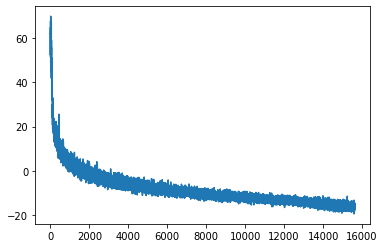

In [6]:
ensemble_size = 7
num_epoch = 5
batch_size = 32

model = PtModel(ensemble_size, in_features=17+7, out_features=17*2).to(device_id)
model.optim = torch.optim.Adam(model.parameters(), lr=0.0001)

model.fit_input_stats(train_in)

idxs = torch.randint(train_in.shape[0], size=[ensemble_size, train_in.shape[0]]).to(device_id)
print('idxs shape:', idxs.shape)
num_batch = int((idxs.shape[-1]/batch_size)+1)

losses = []

for epoch in range(num_epoch):
    print('epoch:', epoch)
    for batch_num in tqdm.trange(num_batch):
        batch_idxs = idxs[:, batch_num * batch_size : (batch_num + 1) * batch_size]
        #print('batch_idxs:', batch_idxs.shape)
        
        loss = 0.01 * (model.max_logvar.sum() - model.min_logvar.sum())
        loss += model.compute_decays()
        
        batch_train_in = train_in[batch_idxs] # (ensemble_size, batch_size, obs_dim)
        batch_train_targ = train_targs[batch_idxs]
        
        #print(batch_train_in.shape)
        mean, logvar = model(batch_train_in, ret_logvar=True)
        inv_var = torch.exp(-logvar)

        train_losses = ((mean - batch_train_targ) ** 2) * inv_var + logvar
        train_losses = train_losses.mean(-1).mean(-1).sum()
        # Only taking mean over the last 2 dimensions
        # The first dimension corresponds to each model in the ensemble

        loss += train_losses
        
        losses.append(loss)

        model.optim.zero_grad()
        loss.backward()
        model.optim.step()
        
        #print(loss)
        
    idxs = shuffle_rows(idxs)
        
        
plt.plot(losses)


# Fitted Result

In [7]:
def draw_plot(ax, title, ground_truth, prediction):    
    """    
    title: string    
    ground_truth: (n, 1)    
    prediction: (n, 1)    
    """    
    gt = ground_truth.flatten()    
    pred = prediction.flatten()    

    sorted_indices = gt.view(-1).sort().indices    
    ax.plot(pred[sorted_indices].detach().cpu().numpy(), 'ro', markersize=1, label='Prediction')    
    ax.plot(gt[sorted_indices].detach().cpu().numpy(), 'bo', markersize=0.3, label='Ground Truth')    
    ax.legend(loc='upper left')    
    errors = pred - gt    
    ax.text(0.65, 0.20, 'MSE: {:.2e}'.format(errors.square().mean()), transform=ax.transAxes)                                                                                             
    ax.text(0.65, 0.15, 'MSE STD: {:.2e}'.format(errors.std()), transform=ax.transAxes)                                                                                                   
    ax.set_xlabel('Samples Sorted by Ground Truth Value')                                                                                                                
    ax.set_ylabel('Values')                                                                                                                                              
    ax.set_title(title)
    #ax.set_facecolor('xkcd:grey')
    #plt.savefig(".png"))                                                                                                            
    #plt.clf()

In [8]:
data_size = training_range[1]-training_range[0]
fitted_size = int(10e3)
idxs = torch.randint(data_size, size=(fitted_size,)).to(device_id)
ensemble_idxs = idxs.expand(ensemble_size, fitted_size)
print('size of idxs:', ensemble_idxs.shape)
batch_train_in = train_in[ensemble_idxs]
mean, var = model(batch_train_in)

ensemble_prediction = mean + torch.rand_like(mean) * var.sqrt()
print('size of ensemble_prediction:', ensemble_prediction.shape)

prediction = ensemble_prediction.sum(dim=0)/ensemble_size
print('size of prediction:', prediction.shape)

fit_state = training['state'][idxs, :]
fit_next_state = training['next_state'][idxs, :]
next_state_pred = fit_state + prediction

print('size of pred_next_state:', next_state_pred.shape)


size of idxs: torch.Size([7, 10000])
size of ensemble_prediction: torch.Size([7, 10000, 17])
size of prediction: torch.Size([10000, 17])
size of pred_next_state: torch.Size([10000, 17])


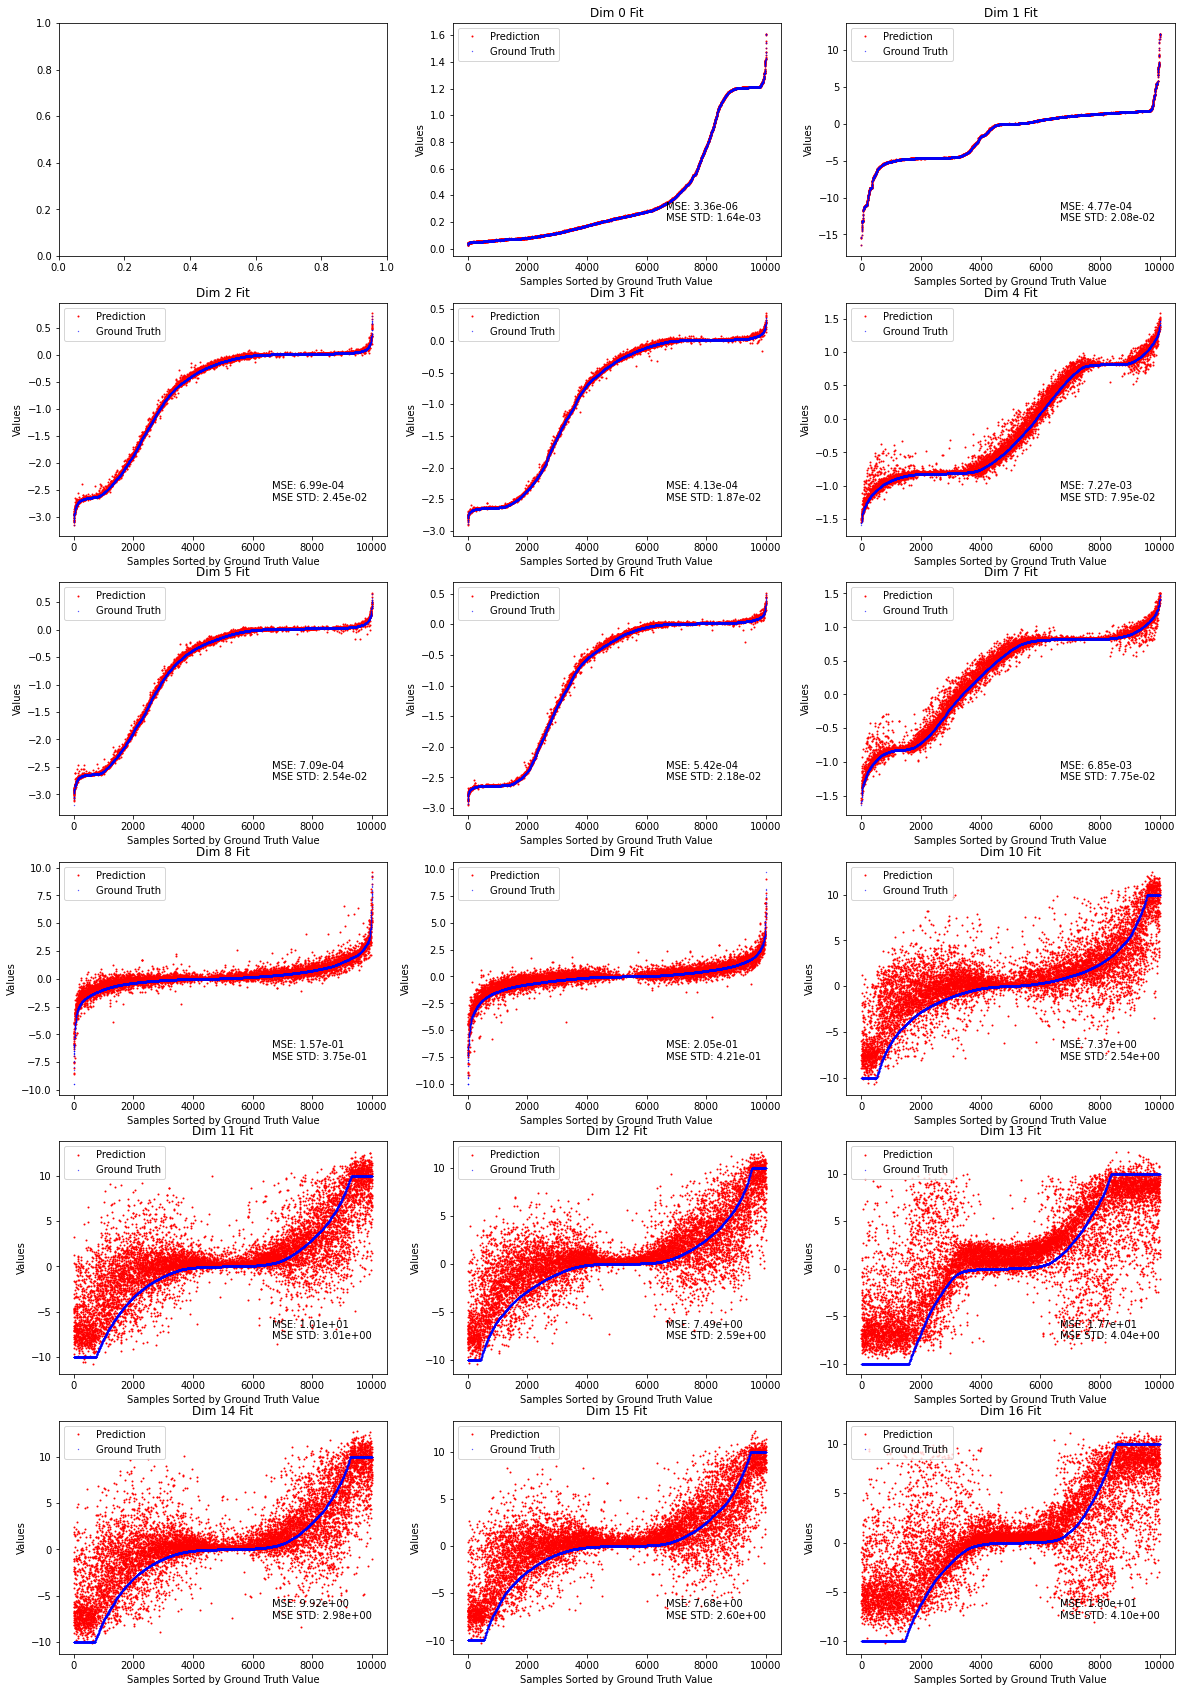

In [9]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
for i in range(6):
    for j in range(3):
        plot_count =  3 * i + j
        if plot_count == 0:
            continue
            #draw_plot(ax[i][j], "Reward Fit", training['reward'], reward_pred)
        elif plot_count > BufferFields['state']:
            continue
        else:
            dim = plot_count - 1
            draw_plot(ax[i][j], "Dim {} Fit".format(dim), fit_next_state[:,dim], next_state_pred[:, dim])
            #draw_plot(ax[i][j], "Dim {} Fit".format(dim), normalized_next_state[:,dim], next_state_pred[:, dim])
fig.patch.set_facecolor('white')
plt.savefig("fig.png")

# Validation

In [10]:
validation_range = (int(100e3), int(110e3))
validation_size = validation_range[1] - validation_range[0]
validation = {}
validation['state'] = replay_buffer._buffer['state'][validation_range[0]:validation_range[1], :]
validation['action'] = replay_buffer._buffer['action'][validation_range[0]:validation_range[1], :]
validation['reward'] = replay_buffer._buffer['reward'][validation_range[0]:validation_range[1], :]
validation['next_state'] = replay_buffer._buffer['next_state'][validation_range[0]:validation_range[1], :]
#validation['prev_state'] = replay_buffer._buffer['prev_state'][validation_range[0]:validation_range[1], :]
#validation['prev_action'] = replay_buffer._buffer['prev_action'][validation_range[0]:validation_range[1], :]

valid_in, valid_targs = obs_proc(validation['state'], validation['next_state'])
print('train_in shape:', valid_in.shape)
print('train_targs shape:', valid_targs.shape)

train_in shape: torch.Size([10000, 24])
train_targs shape: torch.Size([10000, 17])


In [11]:
idxs = torch.arange(validation_size).to(device_id)
ensemble_idxs = idxs.expand(ensemble_size, validation_size)
batch_valid_in = valid_in[ensemble_idxs] # (ensemble_size, batch_size, obs_dim)
mean, var = model(batch_valid_in)

ensemble_prediction = mean + torch.rand_like(mean) * var.sqrt()
print('size of ensemble_prediction:', ensemble_prediction.shape)

prediction = ensemble_prediction.sum(dim=0)/ensemble_size
print('size of prediction:', prediction.shape)

valid_state = validation['state'][idxs, :]
valid_next_state = validation['next_state'][idxs, :]
next_state_pred = valid_state + prediction

print('size of pred_next_state:', next_state_pred.shape)

size of ensemble_prediction: torch.Size([7, 10000, 17])
size of prediction: torch.Size([10000, 17])
size of pred_next_state: torch.Size([10000, 17])


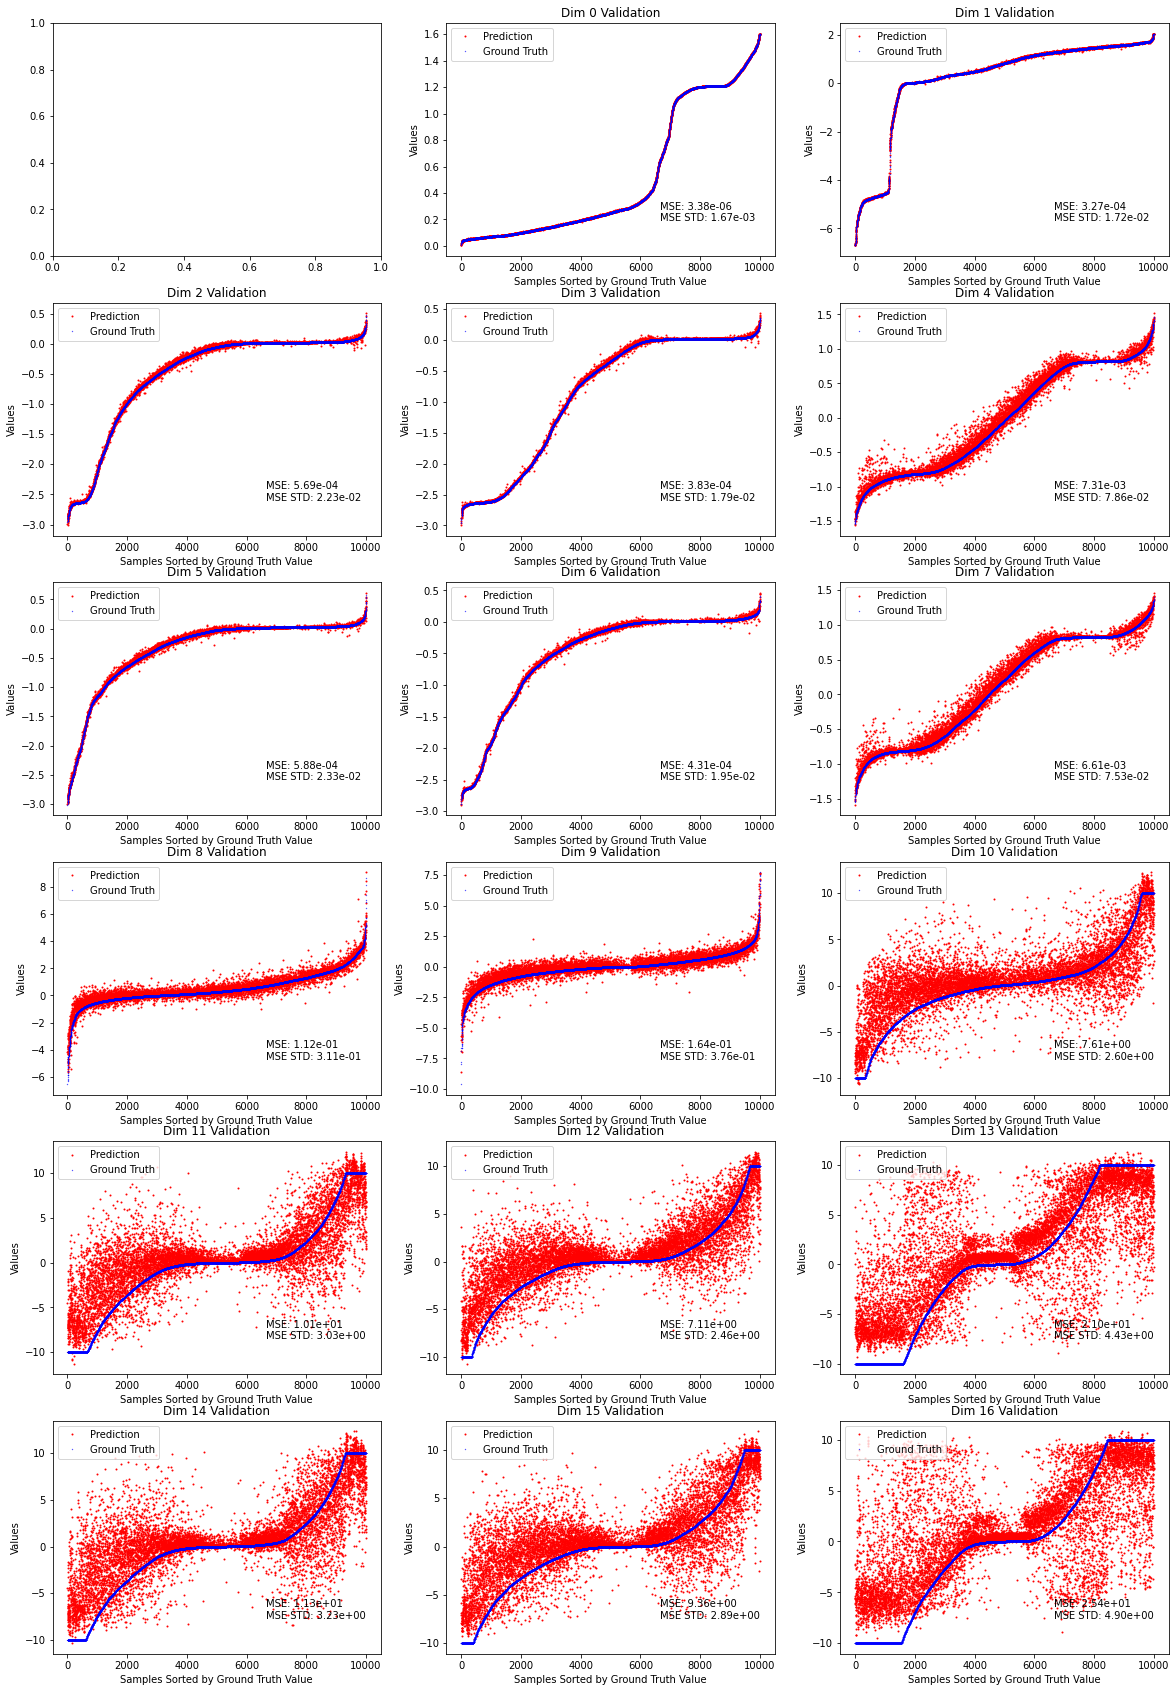

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
for i in range(6):
    for j in range(3):
        plot_count =  3 * i + j
        if plot_count == 0:
            continue
            #draw_plot(ax[i][j], "Reward Fit", training['reward'], reward_pred)
        elif plot_count > BufferFields['state']:
            continue
        else:
            dim = plot_count - 1
            draw_plot(ax[i][j], "Dim {} Validation".format(dim), valid_next_state[:,dim], next_state_pred[:, dim])
            #draw_plot(ax[i][j], "Dim {} Fit".format(dim), normalized_next_state[:,dim], next_state_pred[:, dim])
fig.patch.set_facecolor('white')
plt.savefig("fig.png")